In [1]:
# import numpy as np
import pandas as pd
import scanpy as sc
import anndata
import seaborn as sns
import matplotlib.pyplot as plt
import harmonypy as hm
import os

Set path:

In [2]:
path_results = 'LISI results'

if not os.path.exists(path_results):
    os.makedirs(path_results)

Import data:

In [3]:
dataset_corr = anndata.read_h5ad('smg_dataset_corrected.h5ad', backed = 'r')
donor_corr = anndata.read_h5ad('smg_donor_corrected.h5ad', backed = 'r')

Compute LISI score + store results:

In [4]:
def lisi(adata, variables):
    results = hm.compute_lisi(adata.obsm['X_pca_harmony'], adata.obs, variables)
    data = {}
    for i, variable in enumerate(variables):
        data[f'LISI_{variable}'] = [result[i] for result in results]
    return data

In [5]:
# dataset-corrected data: look at integration score for dataset, cell type and sex
dataset_corr_results = pd.DataFrame(lisi(dataset_corr, ['dataset', 'ann_finest_level', 'sex']))

In [6]:
# donot-corrected data: look at integration score for donor, cell type and sex
donor_corr_results = pd.DataFrame(lisi(donor_corr, ['donor_id', 'ann_finest_level', 'sex']))

In [7]:
max_datasets = len(set(dataset_corr.obs["dataset"]))
max_celltypes = len(set(dataset_corr.obs["ann_finest_level"]))
max_donors = len(set(dataset_corr.obs["donor_id"]))

In [8]:
variables = {
    'Dataset-Corrected': ['LISI_dataset', 'LISI_ann_finest_level', 'LISI_sex'],
    'Donor-Corrected': ['LISI_donor_id', 'LISI_ann_finest_level', 'LISI_sex']
}
titles = ['Integration Variable', 'Cell Type', 'Sex']
corrections = ['Dataset-Corrected', 'Donor-Corrected']

color_dict = {
    'LISI_dataset': 'red',
    'LISI_donor_id': 'red',
    'LISI_ann_finest_level': 'green',
    'LISI_sex': 'blue'
}

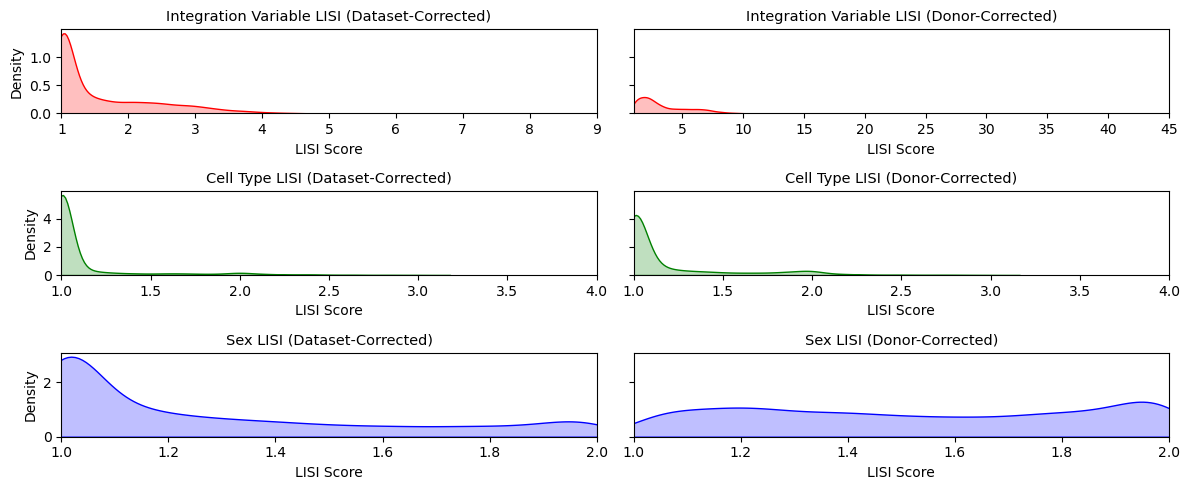

In [9]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12, 5), sharey='row')

for i in range(3):
    for j, correction in enumerate(corrections):
        ax = axes[i, j]
        var = variables[correction][i] 
        subset = dataset_corr_results if correction == 'Dataset-Corrected' else donor_corr_results
        
        # density plot
        sns.kdeplot(data=subset, x=var, fill=True, ax=ax, color = color_dict[var])
        
        ax.set_title(f'{titles[i]} LISI ({correction})', fontsize = 10.5)
        if var.endswith('_sex'):
            ax.set_xlim(1, 2)  
        elif var.endswith('_dataset'):
            ax.set_xlim(1, max_datasets)
        elif var.endswith('_ann_finest_level'):
            ax.set_xlim(1, max_celltypes)
        elif var.endswith('_donor_id'):
            ax.set_xlim(1, max_donors)
            
        ax.set_xlabel('LISI Score')
        ax.set_ylabel('Density')

# Adjust layout
plt.tight_layout()
plt.savefig(f'{path_results}/LISI_scores.png')
plt.show()